In [33]:
!pip install pandana
#!pip uninstall numpy
!pip install numpy
!pip install osmnet
!pip install overpy

     |████████████████████████████████| 47 kB 3.0 MB/s eta 0:00:01
  Created wheel for overpy: filename=overpy-0.6-py3-none-any.whl size=14099 sha256=e7ec02fd5d4bbb5d2164ae6e9bdb379de482d4299e92fc1abe8c2071335ff8f2
  Stored in directory: /Users/Kjaerulff/Library/Caches/pip/wheels/e4/48/d0/aee1180959f33904c422f26205fb0697b603ca67949e5c82de
Successfully built overpy


In [9]:
import pandana, time, os, pandas as pd, numpy as np
from pandana.loaders import osm
%matplotlib inline

In [41]:
import overpy


api = overpy.Overpass()
result = api.query("""node["name"="Copenhagen"];out body;""")




[<overpy.Node id=151714866 lat=32.0237703 lon=-92.0390231>,
 <overpy.Node id=158507047 lat=43.8934390 lon=-75.6738280>,
 <overpy.Node id=287031498 lat=53.5018851 lon=-2.1914305>,
 <overpy.Node id=886089881 lat=28.4153349 lon=-16.5510951>,
 <overpy.Node id=1631314376 lat=42.6760422 lon=-80.9854895>,
 <overpy.Node id=2424531867 lat=-23.6030898 lon=-46.6558238>,
 <overpy.Node id=2665711876 lat=39.4607625 lon=-0.3735820>,
 <overpy.Node id=3138367941 lat=52.2111605 lon=7.1993477>,
 <overpy.Node id=3563539593 lat=-34.8381862 lon=138.4811458>,
 <overpy.Node id=4416857831 lat=38.7073829 lon=-9.1429344>,
 <overpy.Node id=4730952696 lat=51.9642370 lon=7.6248059>,
 <overpy.Node id=4755551240 lat=-20.3120566 lon=-40.2880657>,
 <overpy.Node id=4953781702 lat=25.3024983 lon=55.3992727>,
 <overpy.Node id=5625413297 lat=51.3637688 lon=-0.8057307>,
 <overpy.Node id=5705316313 lat=45.3004771 lon=-72.2317664>,
 <overpy.Node id=8032405490 lat=-12.5228069 lon=-55.7271273>]

In [43]:
result.nodes

[<overpy.Node id=151714866 lat=32.0237703 lon=-92.0390231>,
 <overpy.Node id=158507047 lat=43.8934390 lon=-75.6738280>,
 <overpy.Node id=287031498 lat=53.5018851 lon=-2.1914305>,
 <overpy.Node id=886089881 lat=28.4153349 lon=-16.5510951>,
 <overpy.Node id=1631314376 lat=42.6760422 lon=-80.9854895>,
 <overpy.Node id=2424531867 lat=-23.6030898 lon=-46.6558238>,
 <overpy.Node id=2665711876 lat=39.4607625 lon=-0.3735820>,
 <overpy.Node id=3138367941 lat=52.2111605 lon=7.1993477>,
 <overpy.Node id=3563539593 lat=-34.8381862 lon=138.4811458>,
 <overpy.Node id=4416857831 lat=38.7073829 lon=-9.1429344>,
 <overpy.Node id=4730952696 lat=51.9642370 lon=7.6248059>,
 <overpy.Node id=4755551240 lat=-20.3120566 lon=-40.2880657>,
 <overpy.Node id=4953781702 lat=25.3024983 lon=55.3992727>,
 <overpy.Node id=5625413297 lat=51.3637688 lon=-0.8057307>,
 <overpy.Node id=5705316313 lat=45.3004771 lon=-72.2317664>,
 <overpy.Node id=8032405490 lat=-12.5228069 lon=-55.7271273>]

In [10]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
amenities = ['restaurant', 'bar', 'school']#, 'hospital']
distance = 1000
num_pois = 10
num_categories = len(amenities) + 1 #one for each amenity, plus one extra for all of them combined

# bounding box as a list of llcrnrlat, llcrnrlng, urcrnrlat, urcrnrlng
bbox = [55.6036813, 12.5202081, 55.6942218, 12.6150132] #[55.6336813, 12.5402081, 55.6742218, 12.5950132]  #lat-long bounding box for berkeley/oakland

#(53.2987342,-6.3870259,53.4105416,-6.1148829)
#[12.5795, 55.6775, 12.6081, 55.6688]

#bbox = [1.7752, 36.7799, 1.7889,36.7988 ]


#[y:37.76, x: -122.35, y:37.9, x:-122.17]


#[12.5842713, 55.6723028, 55.6741331,12.5985204]
#55.6723028,12.5842713

#55.6741331,12.5985204


In [11]:
# configure filenames to save/load POI and network datasets
bbox_string = '_'.join([str(x) for x in bbox])
net_filename = 'data/network_{}.h5'.format(bbox_string)
poi_filename = 'data/pois_{}_{}.csv'.format('_'.join(amenities), bbox_string)

In [12]:
# keyword arguments to pass for the matplotlib figure
bbox_aspect_ratio = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10 * bbox_aspect_ratio)}

# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = '#000000'

In [13]:
start_time = time.time()
if os.path.isfile(poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"amenity"~"{}"'.format('|'.join(amenities))
    pois = osm.node_query(lat_min=bbox[0],lng_min=bbox[1], lat_max=bbox[2], lng_max=bbox[3], tags=osm_tags)
    
    # using the '"amenity"~"school"' returns preschools etc, so drop any that aren't just 'school' then save to CSV
    pois = pois[pois['amenity'].isin(amenities)]
    pois.to_csv(poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['amenity', 'name', 'lat', 'lon']].head()

972 POIs loaded from CSV in 0.08 seconds


amenity                         name        lat        lon
0  restaurant  Nørrebro Bryghus Restaurant  55.690217  12.563907
1         bar                   Black Swan  55.686489  12.587433
2  restaurant             Ingolfs Kaffebar  55.650133  12.611974
3  restaurant                     Thai Pan  55.684461  12.559480
4  restaurant                    Rio Bravo  55.674250  12.573063

In [14]:
pois

lat        lon     amenity   cuisine  fvst:navnelbnr microbrewery  \
0    55.690217  12.563907  restaurant  regional        114128.0          yes   
1    55.686489  12.587433         bar       NaN        501959.0          NaN   
2    55.650133  12.611974  restaurant  regional        114043.0          NaN   
3    55.684461  12.559480  restaurant      thai        713340.0          NaN   
4    55.674250  12.573063  restaurant     steak        112944.0          NaN   
..         ...        ...         ...       ...             ...          ...   
967  55.672824  12.574421  restaurant     sushi        950965.0          NaN   
968  55.673578  12.599871         bar       NaN        982781.0          NaN   
969  55.666169  12.566040         bar       NaN        564822.0          NaN   
970  55.668664  12.559522         bar       NaN        988377.0          NaN   
971  55.668217  12.557568  restaurant   spanish        983756.0          NaN   

                                      name  \
0              Nørrebro Bryghus Restaurant   
1                               Black Swan   
2                         Ingolfs Kaffebar   
3                                 Thai Pan   
4                                Rio Bravo   
..                                     ...   
967                             LETZ SUSHI   
968                             Café Inuit   
969  Hotel Tivoli Congress Center Lobbybar   
970                              Tranquilo   
971                                 Camino   

                                         opening_hours         phone  \
0    Mo-Th 12:00-15:00,17:30-22:00; Fr-Sa 12:00-15:...  +45 35300530   
1    Mo-We 15:00-01:00, Th-Sa 15:00-02:00, Su 15:00...           NaN   
2    Mo-Tu 10:00-22:00; We-Sa 10:00-24:00; Su 10:00...  +45 32599596   
3                                          16:30-22:00  +45 35360505   
4                     Mo-Sa 11:30-05:00,Su 17:00-05:00  +45 33117587   
..                                                 ...           ...   
967                                                NaN           NaN   
968                                                NaN           NaN   
969                                                NaN           NaN   
970          15:00-24:00, Fr-Sa 15:00-02:00, Su-Tu off           NaN   
971                     11:30-24:00, Fr-Sa 11:30-02:00  +45 31183030   

                            website  ... payment:android_pay  \
0      https://noerrebrobryghus.dk/  ...                 NaN   
1       http://www.blackswanbar.dk/  ...                 NaN   
2    http://www.ingolfskaffebar.dk/  ...                 NaN   
3            http://www.thaipan.dk/  ...                 NaN   
4          https://www.riobravo.dk/  ...                 NaN   
..                              ...  ...                 ...   
967                             NaN  ...                 NaN   
968                             NaN  ...                 NaN   
969                             NaN  ...                 NaN   
970  https://tranquilo.naervaer.dk/  ...                 NaN   
971                             NaN  ...                 NaN   

    payment:apple_pay payment:card payment:gift_card ref:vatin indoor  \
0                 NaN          NaN               NaN       NaN    NaN   
1                 NaN          NaN               NaN       NaN    NaN   
2                 NaN          NaN               NaN       NaN    NaN   
3                 NaN          NaN               NaN       NaN    NaN   
4                 NaN          NaN               NaN       NaN    NaN   
..                ...          ...               ...       ...    ...   
967               NaN          NaN               NaN       NaN    NaN   
968               NaN          NaN               NaN       NaN    NaN   
969               NaN          NaN               NaN       NaN    NaN   
970               NaN          NaN               NaN       NaN    NaN   
971               NaN          NaN               NaN       N

In [15]:
2*2

4

In [16]:
# how many points of interest of each type of amenity did we retrieve?
pois['amenity'].value_counts()

pois["name"]

0                Nørrebro Bryghus Restaurant
1                                 Black Swan
2                           Ingolfs Kaffebar
3                                   Thai Pan
4                                  Rio Bravo
                       ...                  
967                               LETZ SUSHI
968                               Café Inuit
969    Hotel Tivoli Congress Center Lobbybar
970                                Tranquilo
971                                   Camino
Name: name, Length: 972, dtype: object

In [17]:
start_time = time.time()
if os.path.isfile(net_filename):
    # if a street network file already exists, just load the dataset from that
    network = pandana.network.Network.from_hdf5(net_filename)
    method = 'loaded from HDF5'
else:
    # otherwise, query the OSM API for the street network within the specified bounding box
    network = osm.pdna_network_from_bbox(lat_min=bbox[0],lng_min=bbox[1], lat_max=bbox[2], lng_max=bbox[3])
    method = 'downloaded from OSM'
    
    # identify nodes that are connected to fewer than some threshold of other nodes within a given distance
    lcn = network.low_connectivity_nodes(impedance=1000, count=10, imp_name='distance')
    network.save_hdf5(net_filename, rm_nodes=lcn) #remove low-connectivity nodes and save to h5
    
print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

Network with 21,106 nodes loaded from HDF5 in 1.71 secs


In [18]:
network.precompute(distance + 1)

In [19]:
# initialize the underlying C++ points-of-interest engine
network.init_pois(num_categories=num_categories, max_dist=distance, max_pois=num_pois)

In [20]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', x_col=pois['lon'], y_col=pois['lat'])

Reading parameters from init_pois()
Reading parameters from init_pois()


In [21]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

21,106 nodes


1           2           3           4            5   \
id                                                                    
118725   33.348000   95.097000  104.528000  130.087997   130.973007   
118744  213.123001  229.893997  356.125000  480.441010   582.679016   
118759  550.807007  859.354004  859.354004  865.317017  1000.000000   
118763  246.557999  246.557999  454.628998  472.192993   555.174011   
118764  258.287994  258.287994  466.359009  483.799988   566.903992   

                 6            7            8            9            10  
id                                                                       
118725   134.817001   139.917999   143.753998   151.192001   151.494003  
118744   639.276001   639.276001   639.815002   689.353027   698.119995  
118759  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  
118763   571.492981   631.119019   801.799011   842.338013   861.807983  
118764   583.223022   621.583984   813.528992   850.078003   854.067993

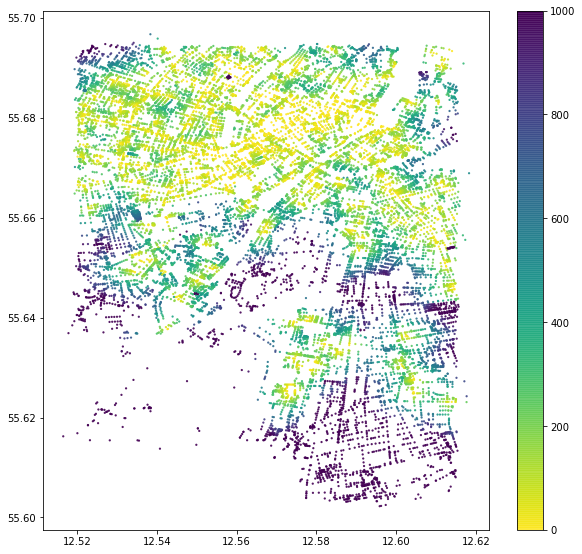

In [22]:
# distance to the nearest amenity of any type
n = 1
fig, ax = network.plot(all_access[n], bbox=bbox, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, 
                              cbar_kwargs=cbar_kwargs) #bmap_kwargs=bmap_kwargs,
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Berkeley/Oakland', fontsize=15)
fig.savefig('images/accessibility-all-east-bay.png', dpi=200, bbox_inches='tight')

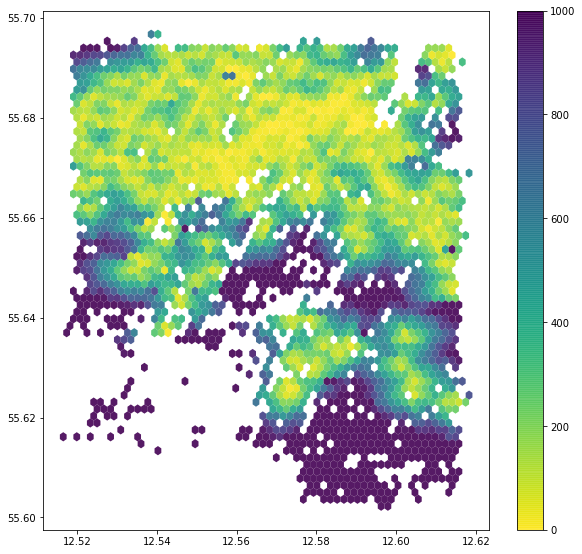

In [23]:
# distance to the nearest amenity of any type, as hexbins
fig, ax = network.plot(all_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs) # bmap_kwargs=bmap_kwargs,
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest amenity around Berkeley/Oakland', fontsize=15)
fig.savefig('images/accessibility-all-hexbin-east-bay.png', dpi=200, bbox_inches='tight')

In [24]:
# initialize each amenity category with the locations specified by the lon and lat columns
for amenity in amenities:
    pois_subset = pois[pois['amenity']==amenity]
    network.set_pois(category=amenity, x_col=pois_subset['lon'], y_col=pois_subset['lat'])




Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()
Reading parameters from init_pois()


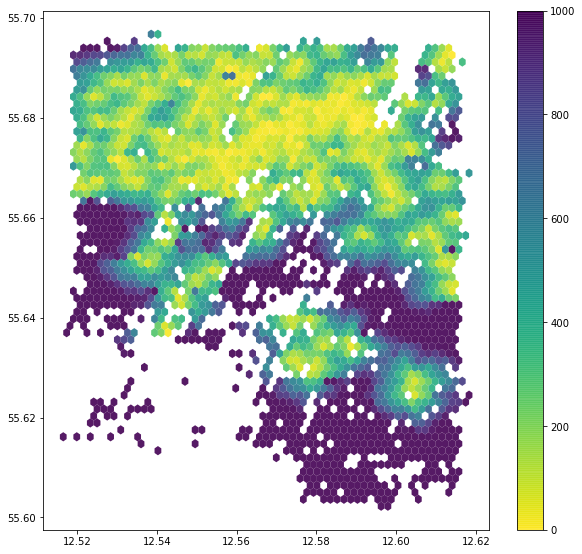

In [25]:
# distance to the nearest restaurant
restaurant_access = network.nearest_pois(distance=distance, category='restaurant', num_pois=num_pois)
fig, ax = network.plot(restaurant_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs) 
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest restaurant around Berkeley/Oakland', fontsize=15)
fig.savefig('images/accessibility-restaurant-east-bay.png', dpi=200, bbox_inches='tight')

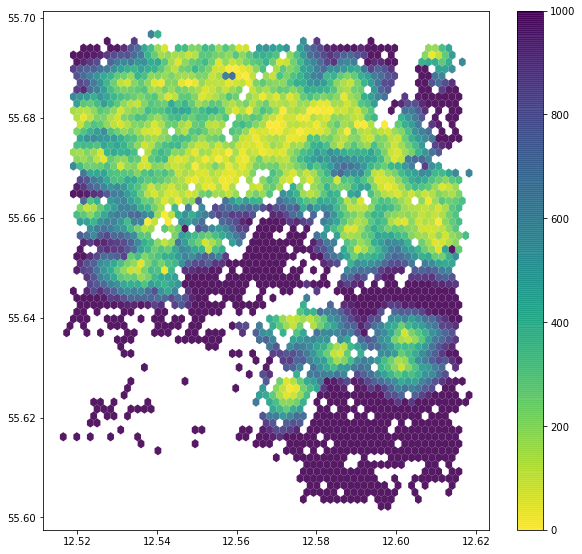

In [26]:
# distance to the nearest bar
bar_access = network.nearest_pois(distance=distance, category='bar', num_pois=num_pois)
fig, ax = network.plot(bar_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs) 
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest bar around Berkeley/Oakland', fontsize=15)
fig.savefig('images/accessibility-bar-east-bay.png', dpi=200, bbox_inches='tight')

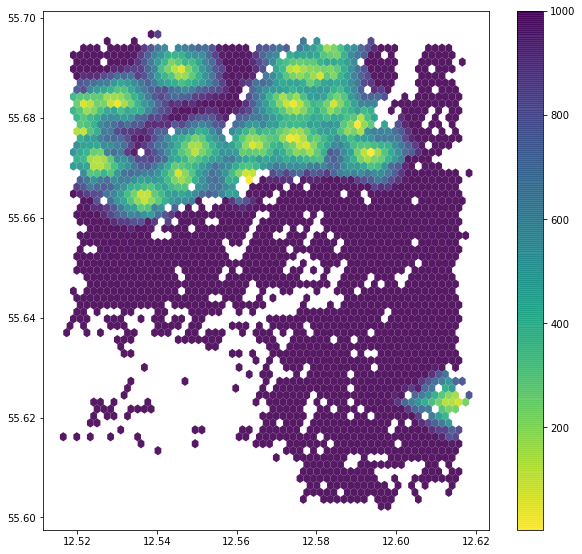

In [27]:
# distance to the nearest school
school_access = network.nearest_pois(distance=distance, category='school', num_pois=num_pois)
fig, ax = network.plot(school_access[1], bbox=bbox, plot_type='hexbin', plot_kwargs=hex_plot_kwargs, 
                             fig_kwargs=fig_kwargs, cbar_kwargs=cbar_kwargs) 
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance (m) to nearest school around Berkeley/Oakland', fontsize=15)
fig.savefig('images/accessibility-school-east-bay.png', dpi=200, bbox_inches='tight')

In [38]:
temp_df = network.nodes_df

temp_df["school_distance"] = school_access[1]
temp_df["restaurant_distance"] = restaurant_access[1]

temp_df

x          y  school_distance  restaurant_distance
id                                                                    
118725      12.562906  55.673985       162.432999            95.097000
118744      12.560034  55.661718       958.510986           213.123001
118759      12.553866  55.657275      1000.000000           859.354004
118763      12.542231  55.654003      1000.000000           246.557999
118764      12.542389  55.653946      1000.000000           258.287994
...               ...        ...              ...                  ...
9087861511  12.593798  55.672097       113.829002            77.039001
9087861513  12.592918  55.672587        47.367001            70.202003
9090083193  12.579655  55.672379       249.195007           156.449997
9090083194  12.579599  55.672297       258.877991           146.766998
9090083195  12.579695  55.672353       253.001999           155.432007

[21106 rows x 4 columns]

In [29]:
!pip install mapboxgl
!pip install kaleido
!pip install plotly==4.12.0

import plotly.express as px
import plotly.io as pio
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()

In [30]:
from mapboxgl.utils import create_color_stops, df_to_geojson
from mapboxgl.viz import CircleViz
from mapboxgl.utils import *
from mapboxgl.viz import *

#token here: pk.eyJ1IjoiZ29vZGdhbWUiLCJhIjoiY2t0YTF4bDUwMWhsMzJ1cWx0NDN2NjNxMyJ9.3yNf5kOkcxOvnjxJuXRlYgm
token = "pk.eyJ1IjoiZ29vZGdhbWUiLCJhIjoiY2t0YTF2b3h6MWhobTJvcGRwc2NkNnY2ZyJ9.wV8JHtziMfNiGSLBdV4xXA" #input('MAPBOX_ACCESS_TOKEN')

# Create a geojson file export from a Pandas dataframe
data = df_to_geojson(temp_df, filename='points.geojson',
              properties=['school_distance'],
              lat='y', lon='x', precision=4)

# Generate data breaks and color stops from colorBrewer
color_breaks = [0,10,100,1000]
color_stops = create_color_stops(color_breaks, colors='YlGnBu')


# Create the viz from the dataframe
viz = CircleViz("/files/points.geojson",
                access_token=token,
                height='400px',
                color_property = "school_distance",
                color_stops = color_stops,
                center = (12.56, 55.655), #12.562906  55.673985 
                zoom = 12,
                below_layer = 'waterway-label',
                opacity = 0.7,
                style = 'mapbox://styles/mapbox/outdoors-v9'
              )


viz.show()



/opt/anaconda3/lib/python3.8/site-packages/IPython/core/display.py:717: UserWarning:

Consider using IPython.display.IFrame instead



In [31]:
heatmap_color_stops = create_color_stops([0.01,0.25,0.5,0.75,1], colors='RdPu')
heatmap_radius_stops = [[0,1], [15, 40]] #increase radius with zoom

color_breaks = [0,10,100,1000,10000]
color_stops = create_color_stops(color_breaks, colors='Spectral')

heatmap_weight_stops = create_weight_stops(color_breaks)

#Create a heatmap
viz = HeatmapViz("/files/points.geojson",
                 access_token=token,
                 weight_property='school_distance',
                 weight_stops=heatmap_weight_stops,
                 color_stops=heatmap_color_stops,
                 radius_stops=heatmap_radius_stops,
                 center = (12.56, 55.655), #12.562906  55.673985 
                 zoom = 12,
                 below_layer = 'waterway-label',
                 opacity = 0.7,
                 style = 'mapbox://styles/mapbox/outdoors-v9'
                )
viz.show()


In [46]:
import plotly.figure_factory as ff
import plotly.express as px

px.set_mapbox_access_token(open(".mapbox_token").read())
df = px.data.carshare()

amenity = "restaurant"

fig = ff.create_hexbin_mapbox(
    data_frame=temp_df, lat="y", lon="x",
    nx_hexagon=40, opacity=0.5, labels={"school_distance": "school_distance"},
    min_count=1, agg_func=np.mean, 
    color=f'{amenity}_distance',  color_continuous_scale='viridis_r'
)

fig.update_layout(mapbox_style="outdoors")
#fig.data[0].hovertemplate = f'Point Count =%{z:,.1f}<extra>Average distance to a {amenity}</extra>'
fig.show()

fig.write_image("images/fig1.png")

In [33]:
import os

if not os.path.exists("images"):
    os.mkdir("images")
    
fig.write_image("images/fig1.png")

In [ ]:
network.